In [81]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use('seaborn-v0_8-whitegrid')



In [82]:
TICKER = 'RHM.DE'
START_DATE = '2019-01-01'
print(f"Pobieranie danych dla {TICKER} od {START_DATE}")
stock = yf.Ticker(TICKER)
df = stock.history(start=START_DATE, interval = '1d', actions = True, auto_adjust = False)


Pobieranie danych dla RHM.DE od 2019-01-01


In [83]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
Date,,,,,,,,
2019-01-02 00:00:00+01:00,76.839996,80.559998,76.400002,80.080002,70.626320,225074,0.0,0.0
2019-01-03 00:00:00+01:00,79.139999,79.239998,76.459999,76.680000,67.627701,163032,0.0,0.0
2019-01-04 00:00:00+01:00,77.639999,81.120003,77.599998,81.120003,71.543541,162107,0.0,0.0
2019-01-07 00:00:00+01:00,82.059998,82.919998,81.199997,82.639999,72.884102,196710,0.0,0.0
2019-01-08 00:00:00+01:00,82.500000,84.180000,80.199997,82.559998,72.813553,243354,0.0,0.0


[*********************100%***********************]  1 of 1 completed


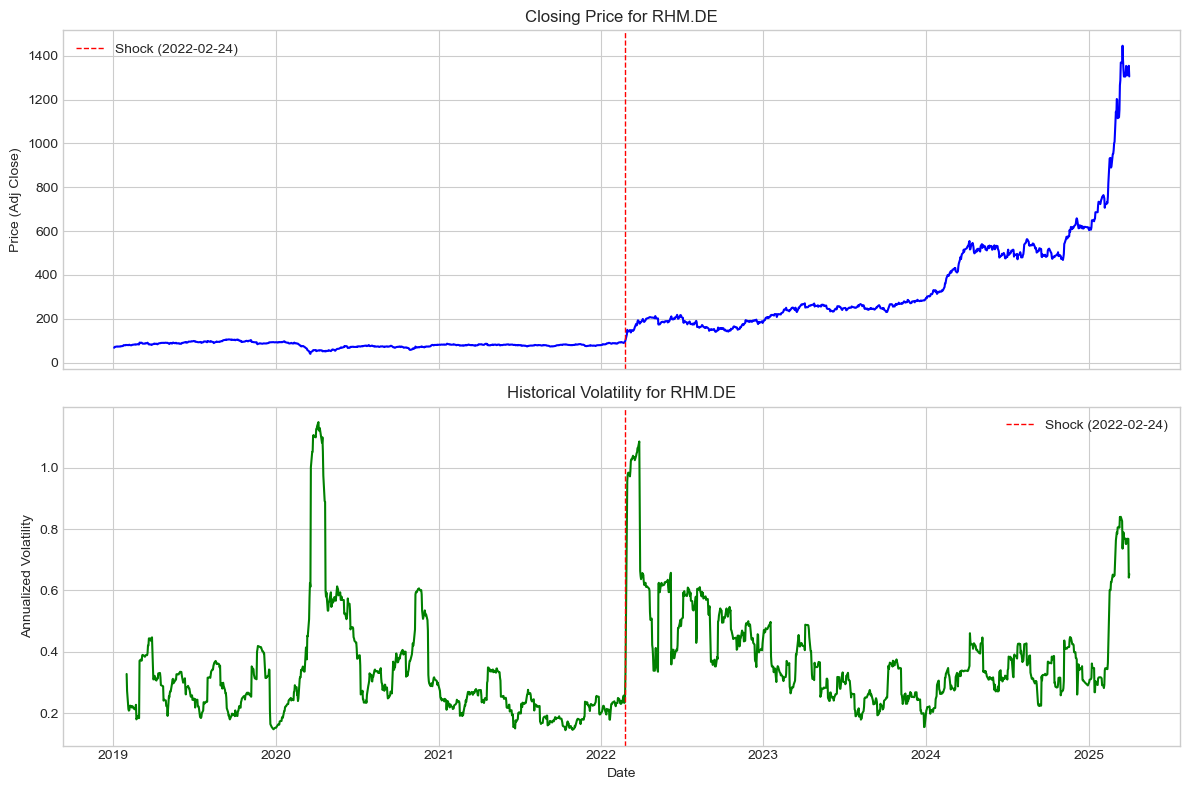

In [84]:
TICKER = 'RHM.DE'
START_DATE = '2019-01-01'
SHOCK_DATE = '2022-02-24'
INTERVAL = '1d'
WINDOW = 21
ANNUALIZATION_FACTOR = 260

df = yf.download(
    tickers=TICKER,
    start=START_DATE,
    interval=INTERVAL,
    actions=True,
    auto_adjust=False
)

if isinstance(df.columns, pd.MultiIndex):
    if len(df.columns.levels) > 1 and TICKER in df.columns.levels[1]:
        df = df.xs(TICKER, level=1, axis=1)
    elif len(df.columns.levels) == 1:
        df.columns = df.columns.droplevel(0)

columns_to_check = [col for col in ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'] 
                   if col in df.columns]
df.dropna(subset=columns_to_check, inplace=True)

df.index = pd.to_datetime(df.index)

if 'Adj Close' in df.columns:
    df['Log_Return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
    df.dropna(subset=['Log_Return'], inplace=True)
    
    df['Realized_Volatility_Daily'] = df['Log_Return'].rolling(window=WINDOW).std() * np.sqrt(ANNUALIZATION_FACTOR)

    fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    
    price_column = 'Adj Close' if 'Adj Close' in df.columns else 'Close'
    ax[0].plot(df.index, df[price_column], color='blue')
    ax[0].set_ylabel(f'Price ({price_column})')
    ax[0].set_title(f'Closing Price for {TICKER}')
    ax[0].grid(True)
    ax[0].axvline(pd.to_datetime(SHOCK_DATE), color='red', linestyle='--', lw=1, 
                 label=f'Shock ({SHOCK_DATE})')
    ax[0].legend()
    
    plot_vol = df['Realized_Volatility_Daily'].dropna()
    ax[1].plot(plot_vol.index, plot_vol, color='green')
    ax[1].set_ylabel('Annualized Volatility')
    ax[1].set_title(f'Historical Volatility for {TICKER}')
    ax[1].grid(True)
    ax[1].axvline(pd.to_datetime(SHOCK_DATE), color='red', linestyle='--', lw=1,
                 label=f'Shock ({SHOCK_DATE})')
    ax[1].legend()
    
    ax[1].xaxis.set_major_locator(mdates.YearLocator())
    ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xlabel('Date')
    plt.tight_layout()
    plt.show()


--- 2.1: Empirical Analysis of B-S Assumptions ---

Data points before shock (2022-02-24): 797
Data points on/after shock (2022-02-24): 793

--- Volatility Analysis (Realized_Volatility_Daily) ---

Volatility Statistics:
      Before Shock  After Shock
mean      0.313695     0.400512
50%       0.261536     0.353570
std       0.165997     0.166071
min       0.145278     0.155337
max       1.148056     1.084821


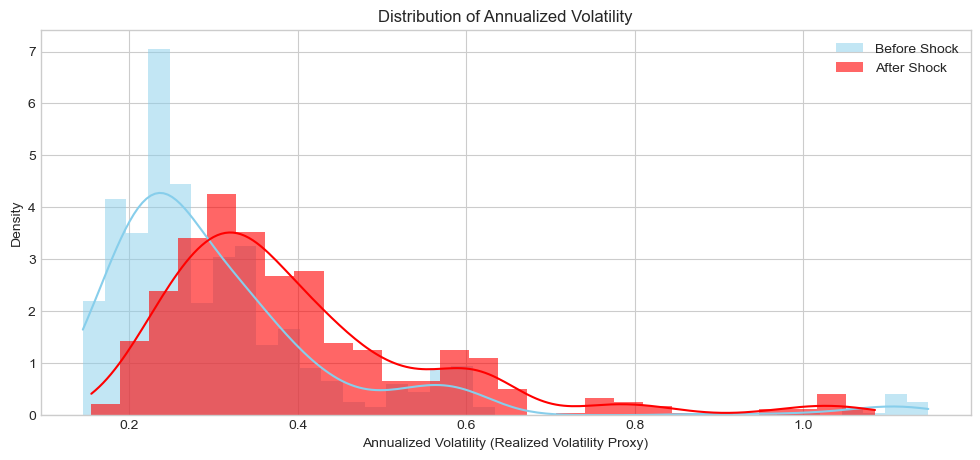


--- Distribution Analysis (Log_Return) ---
          Before Shock  After Shock
Mean          0.000338     0.003339
Std Dev       0.022061     0.027319
Skewness      0.375239     0.740634
Kurtosis      9.976945     9.417459


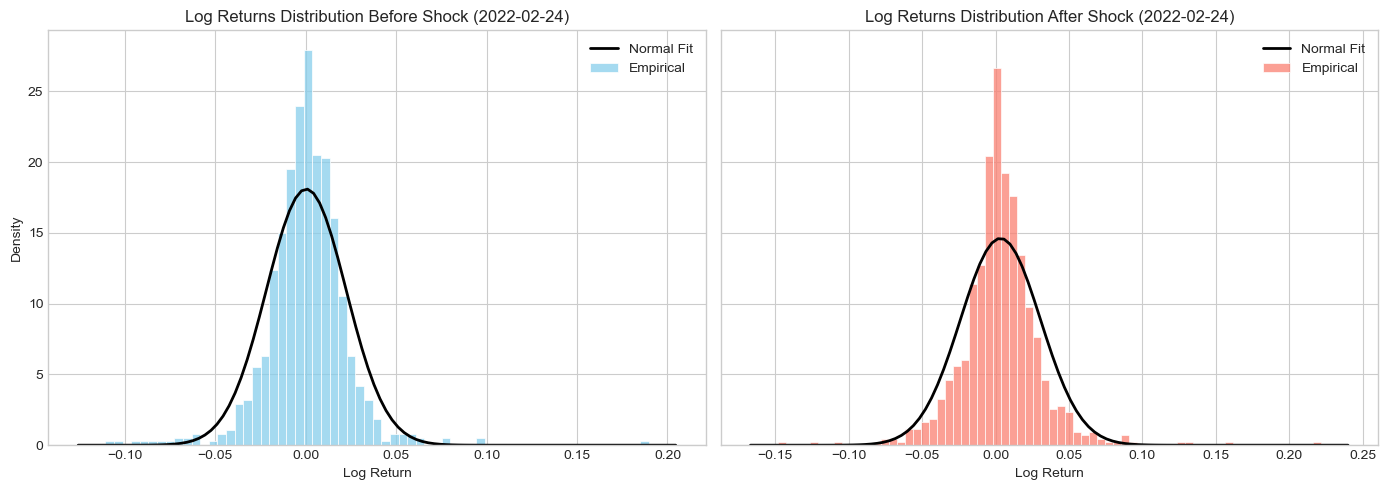

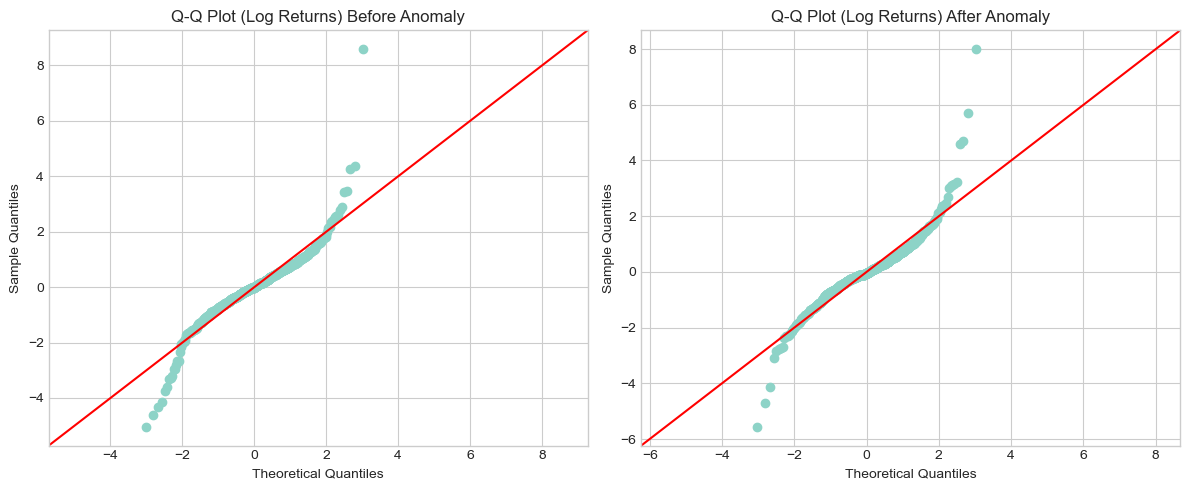


--- Normality Tests (Log Returns) ---
Shapiro-Wilk Test (Before Shock): Statistic=0.9062, p-value=0.0000
Shapiro-Wilk Test (After Shock):  Statistic=0.9039, p-value=0.0000


In [ ]:
import seaborn as sns
from scipy import stats
import statsmodels.api as sm 

# --- 2.1: Empiryczna Analiza Założeń B-S ---

print("\n--- 2.1: Empirical Analysis of B-S Assumptions ---")

df_before_shock = df[df.index < pd.to_datetime(SHOCK_DATE)].copy()
df_after_shock = df[df.index >= pd.to_datetime(SHOCK_DATE)].copy()

print(f"\nData points before shock ({SHOCK_DATE}): {len(df_before_shock)}")
print(f"Data points on/after shock ({SHOCK_DATE}): {len(df_after_shock)}")


print("\n--- Volatility Analysis (Realized_Volatility_Daily) ---")

vol_before = df_before_shock['Realized_Volatility_Daily'].dropna()
vol_after = df_after_shock['Realized_Volatility_Daily'].dropna()

print("\nVolatility Statistics:")
vol_stats = pd.DataFrame({
            'Before Shock': vol_before.describe(),
            'After Shock': vol_after.describe()
        })
print(vol_stats[['Before Shock', 'After Shock']].loc[['mean', '50%', 'std', 'min', 'max']])

plt.figure(figsize=(12, 5))
sns.histplot(vol_before, color="skyblue", label='Before Shock', kde=True, stat="density", linewidth=0)
sns.histplot(vol_after, color="red", label='After Shock', kde=True, stat="density", linewidth=0, alpha=0.6)
plt.title('Distribution of Annualized Volatility')
plt.xlabel('Annualized Volatility (Realized Volatility Proxy)')
plt.legend()
plt.show()
    
print("\n--- Distribution Analysis (Log_Return) ---")
    
returns_before = df_before_shock['Log_Return'].dropna()
returns_after = df_after_shock['Log_Return'].dropna()

return_stats = pd.DataFrame({
        'Before Shock': {
            'Mean': returns_before.mean(),
            'Std Dev': returns_before.std(),
            'Skewness': returns_before.skew(),
            'Kurtosis': returns_before.kurtosis()
        },
        'After Shock': {
            'Mean': returns_after.mean(),
            'Std Dev': returns_after.std(),
            'Skewness': returns_after.skew(),
            'Kurtosis': returns_after.kurtosis()
        }
    })
print(return_stats)

fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
    
sns.histplot(returns_before, ax=ax[0], kde=False, stat="density", label='Empirical', color='skyblue')
mu_before, std_before = stats.norm.fit(returns_before)
xmin, xmax = ax[0].get_xlim()
x_before = np.linspace(xmin, xmax, 100)
p_before = stats.norm.pdf(x_before, mu_before, std_before)
ax[0].plot(x_before, p_before, 'k', linewidth=2, label='Normal Fit')
ax[0].set_title(f'Log Returns Distribution Before Shock ({SHOCK_DATE})')
ax[0].set_xlabel('Log Return')
ax[0].legend()

sns.histplot(returns_after, ax=ax[1], kde=False, stat="density", label='Empirical', color='salmon')
mu_after, std_after = stats.norm.fit(returns_after)
xmin, xmax = ax[1].get_xlim()
x_after = np.linspace(xmin, xmax, 100)
p_after = stats.norm.pdf(x_after, mu_after, std_after)
ax[1].plot(x_after, p_after, 'k', linewidth=2, label='Normal Fit')
ax[1].set_title(f'Log Returns Distribution After Shock ({SHOCK_DATE})')
ax[1].set_xlabel('Log Return')
ax[1].legend()
    
plt.tight_layout()
plt.show()
    
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
sm.qqplot(returns_before, stats.norm, fit=True, line='45', ax=ax[0])
ax[0].set_title('Q-Q Plot (Log Returns) Before Anomaly')
    
sm.qqplot(returns_after, stats.norm, fit=True, line='45', ax=ax[1])
ax[1].set_title('Q-Q Plot (Log Returns) After Anomaly')
    
plt.tight_layout()
plt.show()
    
print("\n--- Normality Tests (Log Returns) ---")
    
shapiro_before = stats.shapiro(returns_before)
shapiro_after = stats.shapiro(returns_after)
print(f"Shapiro-Wilk Test (Before Shock): Statistic={shapiro_before.statistic:.4f}, p-value={shapiro_before.pvalue:.4f}")
print(f"Shapiro-Wilk Test (After Shock):  Statistic={shapiro_after.statistic:.4f}, p-value={shapiro_after.pvalue:.4f}")



In [86]:
from arch import arch_model

print("\n--- Checkpoint 2.2: GARCH Modeling (Baseline) ---")

garch_model = arch_model(returns_before * 100, 
                         mean='Constant', vol='Garch', p=1, q=1, dist='Normal')
print("Fitting the model to pre-shock returns...")

garch_results = garch_model.fit(update_freq=0, disp='off')

print("\nGARCH Model Fitting Results (Pre-Shock Data):")
print(garch_results.summary())
alpha_beta_sum = garch_results.params['alpha[1]'] + garch_results.params['beta[1]']
print(f"\nSum of alpha[1] + beta[1]: {alpha_beta_sum:.4f}")
if alpha_beta_sum >= 1:
    print("Warning: alpha[1] + beta[1] >= 1. Volatility process might be non-stationary (IGARCH).")

print("\nGARCH model fitted successfull.")



--- Checkpoint 2.2: GARCH Modeling (Baseline) ---
Fitting the model to pre-shock returns...

GARCH Model Fitting Results (Pre-Shock Data):
                     Constant Mean - GARCH Model Results                      
Dep. Variable:             Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1653.63
Distribution:                  Normal   AIC:                           3315.25
Method:            Maximum Likelihood   BIC:                           3333.98
                                        No. Observations:                  797
Date:                Wed, Apr 02 2025   Df Residuals:                      796
Time:                        17:32:57   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. In

###### Zalozenie o rozkladzie bledow - bardzo prawdopodobne jest, ze standaryzowane reszty z modelu GARCH nie beda rowniez normalne, wiec mozna sprobowac rozklad t-studenta, ale czy dla celow baselinowych warto? Generalnie zastanowić się czy chcemy ewentualnie baseline budować tak by coś na nim pokazać, czy by uzyskac przy tym mozliwie najlepsze wyniki; wtedy gjr-garch trzeba.
###### Zalozenie, ze pozytywne i negatywne skutki o tej samej wielkosci maja ten sam wplyw na dynamike cen na rynku - nie bardzo?

### Implementacja Symulacji Cen Aktywów z Modelem GARCH
Model GARCH generuje liczne symulacje (n_sims = 20_000) przyszłych cen aktywów, zaczynając od punktu startowego(2022-02-24) i jego rzeczywistej ceny, wykorzystuje zwroty logarytmiczne do aktualizacji cen w kolejnych dniach; Wyniki -> wartość mediany, jako najbardziej prawdopodobny scenariusz, przedział ufności pokazujący zakres niepewnosści.

chyba źle?


--GARCH Counterfactual Simulation--
Simulation horizon: 793 steps (trading days after 2022-02-24)

Running 20000 simulations for 793 steps...

Finished generating 20000 simulations.
Starting price for simulation (last actual price before shock): 92.45
Generating counterfactual simulation plots...


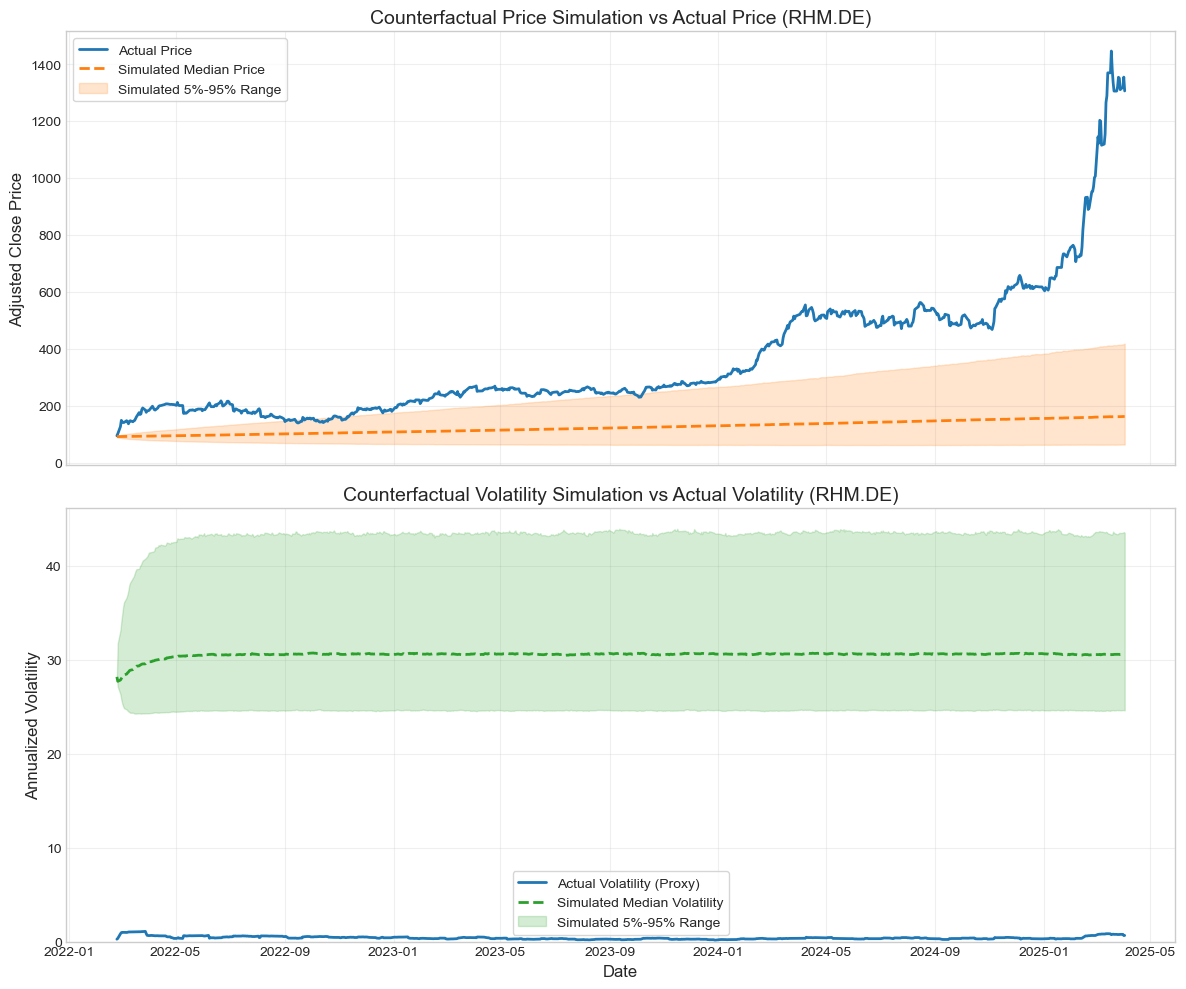

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("\n--GARCH Counterfactual Simulation--")

n_steps = len(df_after_shock)
print(f"Simulation horizon: {n_steps} steps (trading days after {SHOCK_DATE})")
n_sims = 20_000
print(f"\nRunning {n_sims} simulations for {n_steps} steps...")

forecast = garch_results.forecast(horizon=n_steps, method='simulation', simulations=n_sims)

sim_mean_scaled = forecast.simulations.values
sim_mean_scaled = sim_mean_scaled[0].T

sim_variance_unscaled = forecast.simulations.residual_variances
sim_variance_unscaled = sim_variance_unscaled[0].T

print(f"\nFinished generating {n_sims} simulations.")

sim_log_returns = sim_mean_scaled / 100.0

last_actual_price = df.loc[df.index < pd.to_datetime(SHOCK_DATE), 'Adj Close'].iloc[-1]
print(f"Starting price for simulation (last actual price before shock): {last_actual_price:.2f}")

sim_prices = np.zeros((n_steps, n_sims))
current_prices = np.full(n_sims, last_actual_price)

for t in range(n_steps):
    current_prices = current_prices * np.exp(sim_log_returns[t, :])
    sim_prices[t, :] = current_prices

sim_prices_df = pd.DataFrame(sim_prices, index=df_after_shock.index,
                            columns=[f'Sim_{i+1}' for i in range(n_sims)])

sim_prices_stats = pd.DataFrame({
    'Median': sim_prices_df.median(axis=1),
    'Quantile_05': sim_prices_df.quantile(0.05, axis=1),
    'Quantile_95': sim_prices_df.quantile(0.95, axis=1)
}, index=df_after_shock.index)

sim_volatility_annualized = np.sqrt(sim_variance_unscaled * ANNUALIZATION_FACTOR)
sim_vol_df = pd.DataFrame(sim_volatility_annualized, index=df_after_shock.index,
                        columns=[f'Sim_{i+1}' for i in range(n_sims)])

sim_vol_stats = pd.DataFrame({
    'Median': sim_vol_df.median(axis=1),
    'Quantile_05': sim_vol_df.quantile(0.05, axis=1),
    'Quantile_95': sim_vol_df.quantile(0.95, axis=1)
}, index=df_after_shock.index)

print("Generating counterfactual simulation plots...")

fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

axes[0].plot(df_after_shock.index, df_after_shock['Adj Close'], label='Actual Price', color='#1f77b4', linewidth=2)
axes[0].plot(sim_prices_stats.index, sim_prices_stats['Median'], label='Simulated Median Price', color='#ff7f0e', linewidth=2, linestyle='--')
axes[0].fill_between(sim_prices_stats.index, sim_prices_stats['Quantile_05'], sim_prices_stats['Quantile_95'], color='#ff7f0e', alpha=0.2, label='Simulated 5%-95% Range')
axes[0].set_title(f'Counterfactual Price Simulation vs Actual Price ({TICKER})', fontsize=14)
axes[0].set_ylabel('Adjusted Close Price', fontsize=12)
axes[0].legend(frameon=True, fontsize=10)
axes[0].grid(True, alpha=0.3)

actual_vol_after = df_after_shock['Realized_Volatility_Daily'].dropna()
axes[1].plot(actual_vol_after.index, actual_vol_after, label='Actual Volatility (Proxy)', color='#1f77b4', linewidth=2)
axes[1].plot(sim_vol_stats.index, sim_vol_stats['Median'], label='Simulated Median Volatility', color='#2ca02c', linewidth=2, linestyle='--')
axes[1].fill_between(sim_vol_stats.index, sim_vol_stats['Quantile_05'], sim_vol_stats['Quantile_95'], color='#2ca02c', alpha=0.2, label='Simulated 5%-95% Range')
axes[1].set_title(f'Counterfactual Volatility Simulation vs Actual Volatility ({TICKER})', fontsize=14)
axes[1].set_ylabel('Annualized Volatility', fontsize=12)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].legend(frameon=True, fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(bottom=0)

plt.tight_layout()
plt.show()